In [198]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from scipy.optimize import minimize, Bounds
from scipy.stats import logistic, norm
from numpy.linalg import inv
from mpl_toolkits.mplot3d import Axes3D

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis,QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

y|x ~ N(x'b,o^2) = 

$$
\prod \frac{1}{\sigma \sqrt{2\pi}}exp\{-(y-x'\beta)^2/2\sigma\}
$$

forenkler og antar at $\sigma=1$ er kjent. sitter da igjen med $\sum -(y_n-x_n'\beta)^2$ som skal maksimeres

In [7]:
N = 100
β = np.array([2,2])

x = np.random.uniform(size=N)
X = np.c_[np.ones(N),x]
y = X@β+np.random.normal(size=N)

In [8]:
def logL(β):
    sum_ = 0
    for n in range(N):
        sum_ += (y[n]-(β[0]+β[1]*x[n]))**2
    return sum_

In [14]:
def logL1(β):
    return (y-X@β).T@(y-X@β)

In [9]:
x0 = np.zeros(len(β))
minimize(logL,x0)

      fun: 82.88870493081164
 hess_inv: array([[ 0.01973899, -0.02996772],
       [-0.02996772,  0.06093122]])
      jac: array([-3.81469727e-06,  2.86102295e-06])
  message: 'Optimization terminated successfully.'
     nfev: 28
      nit: 5
     njev: 7
   status: 0
  success: True
        x: array([2.19818459, 1.59127661])

In [15]:
x0 = np.zeros(len(β))
minimize(logL1,x0)

      fun: 82.88870493081151
 hess_inv: array([[ 0.01973899, -0.02996772],
       [-0.02996772,  0.06093123]])
      jac: array([ 0.00000000e+00, -9.53674316e-07])
  message: 'Optimization terminated successfully.'
     nfev: 28
      nit: 5
     njev: 7
   status: 0
  success: True
        x: array([2.19818468, 1.59127645])

In [11]:
inv(X.T@X)@X.T@y

array([2.19818466, 1.5912765 ])

skal nå gjøre samme med logit estimator som ikke har closed form. betyr at må løses numerisk for hver gang.

har betinget bernoulli fordelt. parameter i fordeling avhenger av X, $p_{Y|X}(y|x) = p(x)^y+(1-p(x))^{(1-y)}$, der $p(x)=g(\beta'x)$ og der $g(\cdot)$ er en CDF (i praksis logistisk eller normal). 

y log(p(x)) + (1-y)log(1-p(x))

In [21]:
y = (y > y.mean()).astype(int)

In [51]:
def logL(b):
    sum_ = 0
    g = logistic.cdf
    for n in range(len(y)):
        sum_ += y[n]*np.log(g(b[0]+b[1]*x[n]))+(1-y[n])*np.log(1-g(b[0]+b[1]*x[n]))
    return -sum_

In [52]:
def logL1(b):
    sum_ = 0
    g = logistic.cdf
    for n in range(len(y)):
        sum_ += y[n]*np.log(g(b.T@X[n,:]))+(1-y[n])*np.log(1-g(b.T@X[n,:]))
    return -sum_

In [53]:
x0 = np.zeros(len(β))
minimize(logL,x0)

      fun: 60.001891984031985
 hess_inv: array([[ 0.20458877, -0.32060546],
       [-0.32060546,  0.6567301 ]])
      jac: array([0.00000000e+00, 9.53674316e-07])
  message: 'Optimization terminated successfully.'
     nfev: 36
      nit: 8
     njev: 9
   status: 0
  success: True
        x: array([-1.61407446,  3.27847614])

In [54]:
x0 = np.zeros(len(β))
minimize(logL1,x0)

      fun: 60.001891984031985
 hess_inv: array([[ 0.20458877, -0.32060546],
       [-0.32060546,  0.6567301 ]])
      jac: array([0.00000000e+00, 9.53674316e-07])
  message: 'Optimization terminated successfully.'
     nfev: 36
      nit: 8
     njev: 9
   status: 0
  success: True
        x: array([-1.61407446,  3.27847614])

In [29]:
b = minimize(logL,x0).x

In [27]:
sm.Logit(y,X).fit().params

Optimization terminated successfully.
         Current function value: 0.600019
         Iterations 5


array([-1.6140741 ,  3.27847542])

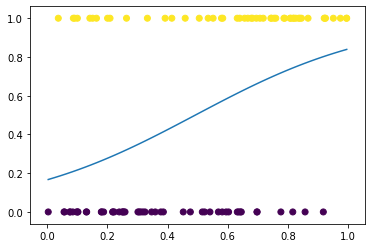

In [34]:
m=50
x_grid = np.linspace(min(x),max(x),m)
plt.plot(x_grid,logistic().cdf(b[0]+x_grid*b[1]))
plt.scatter(x,y,c=y)

jeg har lyst til å utvide til flere variabler. generelt kan vi tenke på at $x'b+u \in \mathbb{r}$ og at det er en tresholdverdi som avgjør, $y = I\{x'b+u>c\}$. Ikke deterministisk sammenheng fordi vi har et støyledd (tenk: observerer ikke alle variabler som påvirker latent variabel).

In [151]:
β = np.array([2,2])
x1 = np.random.uniform(size=N)
x2 = np.random.uniform(size=N)
X = np.c_[x1,x2]
y = X@β+X**2@β+np.random.normal(size=N)
y = (y>y.mean()).astype(int)

In [152]:
x1_grid = np.linspace(min(x1),max(x1),m)
x2_grid = np.linspace(min(x2),max(x2),m)
X1,X2 = np.meshgrid(x1_grid,x2_grid)


In [153]:
logreg = LogisticRegression(penalty='none',fit_intercept=False).fit(X,y)
b = logreg.coef_

In [155]:
X_grid = np.c_[X1.flatten(),X2.flatten()]

In [156]:
P = logreg.predict_proba(X_grid)[:,1]
P = P.reshape((m,m))

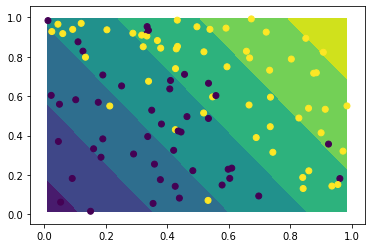

In [157]:
plt.contourf(X1,X2,P)
plt.scatter(x1,x2,c=y)

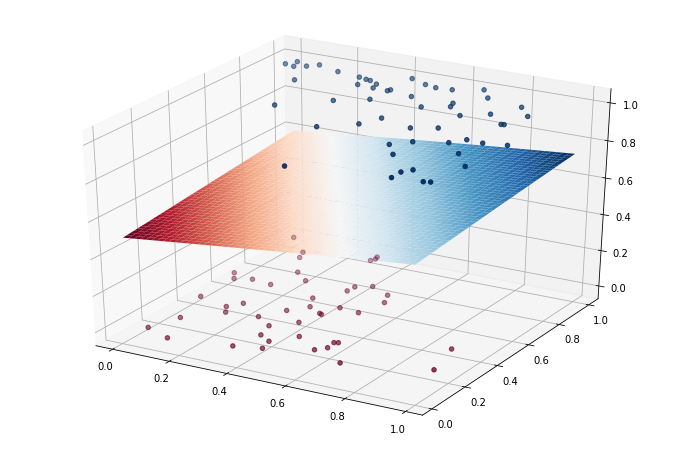

In [161]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111,projection="3d")
ax.plot_surface(X1,X2,P,cmap='RdBu')
ax.scatter(x1,x2,y,c=y,cmap='RdBu')

In [169]:
knn = KNeighborsClassifier().fit(X,y)
P = knn.predict_proba(X_grid)[:,1]
P = P.reshape((m,m))

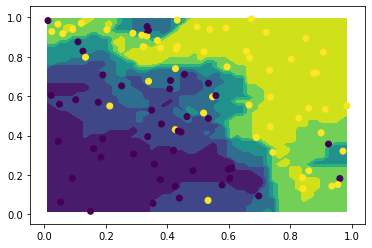

In [170]:
plt.contourf(X1,X2,P)
plt.scatter(x1,x2,c=y)

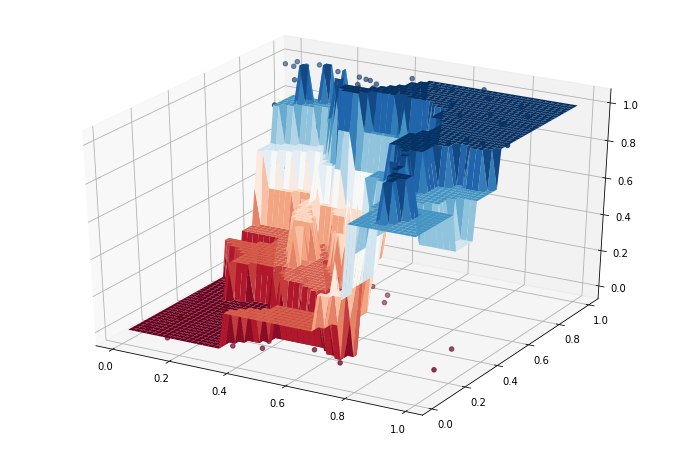

In [171]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111,projection="3d")
ax.plot_surface(X1,X2,P,cmap='RdBu')
ax.scatter(x1,x2,y,c=y,cmap='RdBu')

ser at det kan være greit med sepeatation of concern mellom å beskrive sammenheng i data vi observerer og generalisere til nye.

kan også forsøke å knytte de empiriske resultatene jeg lærer om data til teoretiske egenskaper når jeg simulerer de...

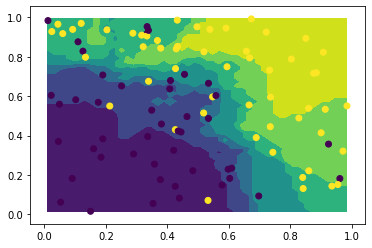

In [173]:
knn = KNeighborsClassifier(10).fit(X,y)
P = knn.predict_proba(X_grid)[:,1]
P = P.reshape((m,m))
plt.contourf(X1,X2,P)
plt.scatter(x1,x2,c=y)

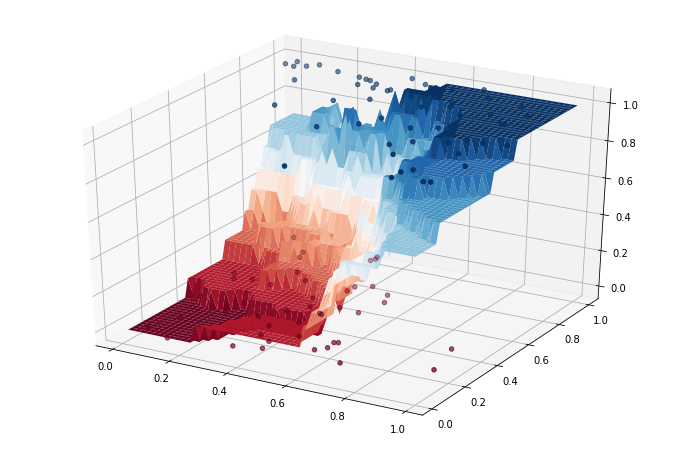

In [174]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111,projection="3d")
ax.plot_surface(X1,X2,P,cmap='RdBu')
ax.scatter(x1,x2,y,c=y,cmap='RdBu')

ser at decision boundary skal være sirkel.. skal se om jeg kan få dette til med logreg hvis jeg gjør basis ekspansjon..

In [175]:
X_ = np.c_[X,x1**2,x2**2]

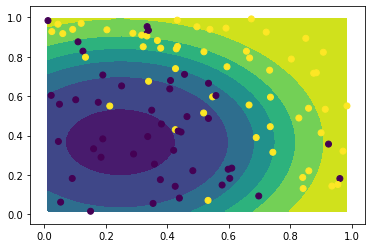

In [181]:
logreg = LogisticRegression(penalty='none',fit_intercept=False).fit(X_,y)
X_grid_ = np.c_[X_grid,X_grid[:,0]**2,X_grid[:,1]**2]
P = logreg.predict_proba(X_grid_)[:,1]
P = P.reshape((m,m))
plt.contourf(X1,X2,P)
plt.scatter(x1,x2,c=y)

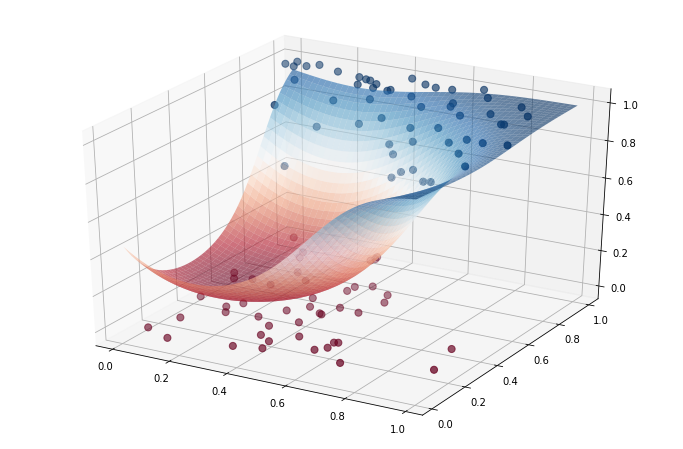

In [186]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111,projection="3d")
ax.plot_surface(X1,X2,P,cmap='RdBu',alpha=0.6)
ax.scatter(x1,x2,y,c=y,cmap='RdBu',s=50)

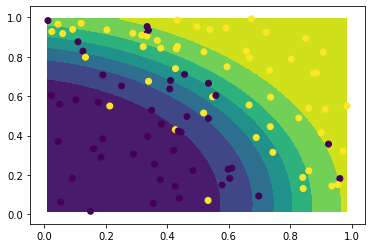

In [191]:
qda = LinearDiscriminantAnalysis().fit(X_,y)
X_grid_ = np.c_[X_grid,X_grid[:,0]**2,X_grid[:,1]**2]
P = qda.predict_proba(X_grid_)[:,1]
P = P.reshape((m,m))
plt.contourf(X1,X2,P)
plt.scatter(x1,x2,c=y)

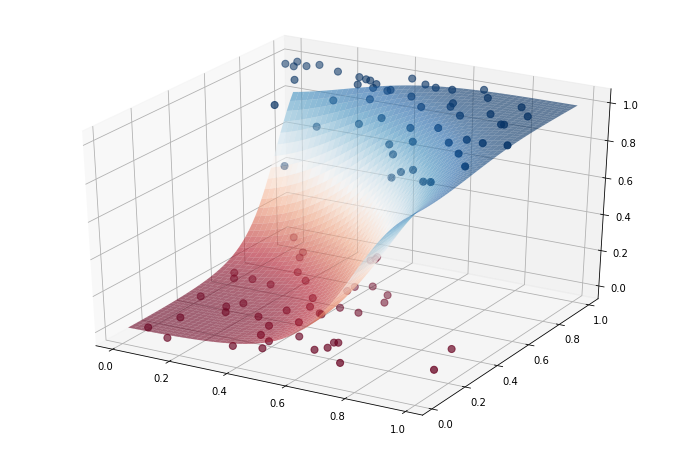

In [192]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111,projection="3d")
ax.plot_surface(X1,X2,P,cmap='RdBu',alpha=0.6)
ax.scatter(x1,x2,y,c=y,cmap='RdBu',s=50)

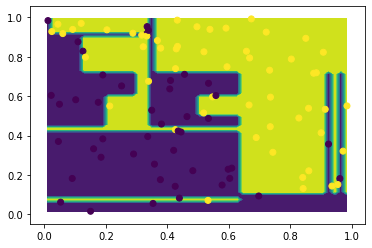

In [200]:
tree = DecisionTreeRegressor().fit(X,y)
P = tree.predict(X_grid)
P = P.reshape((m,m))
plt.contourf(X1,X2,P)
plt.scatter(x1,x2,c=y)

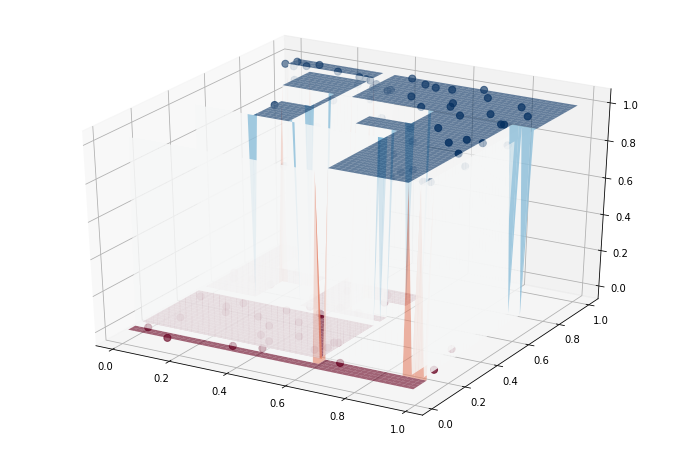

In [201]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111,projection="3d")
ax.plot_surface(X1,X2,P,cmap='RdBu',alpha=0.6)
ax.scatter(x1,x2,y,c=y,cmap='RdBu',s=50)